<a href="https://colab.research.google.com/github/lizhieffe/zhi_llm/blob/main/colabs/%5BCanonical%5D_Use_zhi_llm_module.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tutorial for "LLM from Scratch" Chapter 07

https://drive.google.com/drive/u/1/folders/1a9jbhCJr_dddOT-m-4G9MgBTpOdaCs7Q

Eval scores

- GPT-2 124M SFT 2 epochs: 38
- GPT-2 124M LoRA 2 epochs: 35
- GPT-2 355M LoRA 2 epochs: 46
- GPT-2 355M LoRA 4 epochs: 54
- LLAMA3 8B: 85

# Install the zhi_llm module

In [80]:
# @title Fetch the module from github

MODULE_NAME = "zhi_llm"

%cd /content

!git config --global user.email "lizhieffe@gmail.com"
!git config --global user.name "lizhieffe"

!git clone https://github.com/lizhieffe/"$MODULE_NAME".git

%ls

/content
fatal: destination path 'zhi_llm' already exists and is not an empty directory.
'=2.15.0'   gpt2/             instruction-data.json   __pycache__/   zhi_llm/
'=4.66'     gpt_download.py   previous_chapters.py    sample_data/


In [81]:
# @title Install dependencies

!pip install uv
!uv pip install -r /content/$MODULE_NAME/requirements.txt

/bin/bash: line 1: /usr/local/bin/uv: Permission denied


In [82]:
# @title Install the zhi_llm module in editable mode

!pip install -e /content/$MODULE_NAME

# Make the installed module in editable model auto-refresh.
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f"/content/{MODULE_NAME}")

from zhi_llm.src.models import gpt2

Obtaining file:///content/zhi_llm
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for zhi-llm (pyproject.toml) ... done
  Created wheel for zhi-llm: filename=zhi_llm-0.2-0.editable-py3-none-any.whl size=1472 sha256=b72c3affb874cc48751effee72a6df7418c73120961ef250104708c04a70c585
  Stored in directory: /tmp/pip-ephem-wheel-cache-28xo1tmj/wheels/e1/de/68/d4ffc5ac006b8236b4b06e3039ce05ee7dca73f0042534b193
Successfully built zhi-llm
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
%ls
%cd /content
%ls


'=2.15.0'   gpt2/             instruction-data.json   __pycache__/   zhi_llm/
'=4.66'     gpt_download.py   previous_chapters.py    sample_data/
/content
'=2.15.0'   gpt2/             instruction-data.json   __pycache__/   zhi_llm/
'=4.66'     gpt_download.py   previous_chapters.py    sample_data/


In [84]:
# @title Imports

import torch
import torch.nn as nn

# GPT-2 Config

We don't use GPT-3 because
- GPT-3 needs a cluster to run while GPT-2 can run on PC
- GPT-2 weights are open

In [85]:
BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.1,
    # The bias in ATTN qkv linear layer.
    # These are not used in recent models since they don't improve the modeling performance.
    # But they are used in GPT-2.
    "qkv_bias": True,
    "pos_emb_type": "abs",
}

In [86]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
    "rope gpt2-small (124M)": {
        "emb_dim": 768, "n_layers": 12, "n_heads": 12, "pos_emb_type": "sinusoidal"},
}

In [87]:
import pprint

CHOOSE_MODEL = "gpt2-small (124M)"
# CHOOSE_MODEL = "gpt2-medium (355M)"
CHOOSE_MODEL = "rope gpt2-small (124M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

pprint.pprint(f"{BASE_CONFIG=}")
print(f"{model_size=}")

("BASE_CONFIG={'vocab_size': 50257, 'context_length': 1024, 'drop_rate': 0.1, "
 "'qkv_bias': True, 'pos_emb_type': 'sinusoidal', 'emb_dim': 768, 'n_layers': "
 "12, 'n_heads': 12}")
model_size='124M'


# Device

In [88]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Instruction Following DS

## Download

In [89]:
import json
import os
import urllib
import pprint

def download_and_load_file(file_path, url) -> list[dict[str, str]]:
  if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
      text_data = response.read().decode("utf-8")
      print(f"{len(text_data)=}")
    with open(file_path, "w", encoding="utf-8") as file:
      file.write(text_data)
  with open(file_path, "r") as file:
    data = json.load(file)
  return data

file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

for it in data[:5]:
  pprint.pprint(it)

Number of entries: 1100
{'input': 'freind --> friend',
 'instruction': 'Evaluate the following phrase by transforming it into the '
                'spelling given.',
 'output': 'The spelling of the given phrase "freind" is incorrect, the '
           'correct spelling is "friend".'}
{'input': 'He go to the park every day.',
 'instruction': 'Edit the following sentence for grammar.',
 'output': 'He goes to the park every day.'}
{'input': '',
 'instruction': 'Convert 45 kilometers to meters.',
 'output': '45 kilometers is 45000 meters.'}
{'input': '',
 'instruction': "Rewrite this sentence to start with 'Although': Despite the "
                'rain, they went for a walk.',
 'output': 'Although it was raining, they went for a walk.'}
{'input': '',
 'instruction': 'What are the first 10 square numbers?',
 'output': '1, 4, 9, 16, 25, 36, 49, 64, 81, 100.'}


## Format prompt

In [90]:
TEMPLATE_WITH_INPUT = """Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
{instruction}

### Input:
{input}
"""

TEMPLATE_WO_INPUT = """Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
{instruction}
"""

TEMPLATE_RESP = """### Response:
{response}
"""

def format_input(entry: dict[str, str], include_resp: bool = True) -> str:
  instruction = entry["instruction"]
  response = entry["output"]
  if "input" in entry and entry['input']:
    input = entry["input"]
    ret = TEMPLATE_WITH_INPUT.format(instruction=instruction, input=input, response=response)
  else:
    ret = TEMPLATE_WO_INPUT.format(instruction=instruction, response=response)

  if include_resp:
    return ret + "\n" + TEMPLATE_RESP.format(response=response)
  else:
    return ret

print(format_input(data[50]))
print(format_input(data[999]))



Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.



## Split the data

In [91]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print(f"{len(train_data)=}")
print(f"{len(val_data)=}")
print(f"{len(test_data)=}")

len(train_data)=935
len(val_data)=55
len(test_data)=110


# BPE Tokenizer

See chap 02 for details

In [92]:
!uv pip install tiktoken

from importlib.metadata import version
import tiktoken
print(f"{version('tiktoken')=}")

tokenizer = tiktoken.get_encoding("gpt2")
print(f"{tokenizer.name=}")
assert tokenizer.n_vocab == BASE_CONFIG["vocab_size"]

text = (
"Hello, do you like tea? <|endoftext|> In the sunlit terraces"
"of someunknownPlace."
)
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(f"{integers=}")

decoded = tokenizer.decode(integers)
print(f"{decoded=}")


text1 = "Every effort moves you"
text2 = "Every day holds a"
batch = tokenizer.encode_batch([text1, text2])
batch = torch.tensor(batch)
print(f"{batch.shape=}")

decoded = tokenizer.decode_batch(batch.numpy())
print(f"{decoded=}")
assert decoded == [text1, text2]

/bin/bash: line 1: /usr/local/bin/uv: Permission denied
version('tiktoken')='0.9.0'
tokenizer.name='gpt2'
integers=[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]
decoded='Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.'
batch.shape=torch.Size([2, 4])
decoded=['Every effort moves you', 'Every day holds a']


# Prepare Dataset

In [93]:
import torch
from torch.utils.data import Dataset, DataLoader

class InstructionDataset(Dataset):
  def __init__(self, data, tokenizer):
    super().__init__()
    texts = [format_input(it) for it in data]
    self.tokens = tokenizer.encode_batch(texts)
    assert len(data) == len(self.tokens)
    assert tokenizer.decode(self.tokens[0]) == texts[0]

  def __len__(self):
    return len(self.tokens)

  def __getitem__(self, index):
    return self.tokens[index]

dataset = InstructionDataset(data, tokenizer)
print(f"{len(dataset)=}")
print(f"{dataset[0]=}")

len(dataset)=1100
dataset[0]=[21106, 318, 281, 12064, 326, 8477, 257, 4876, 13, 19430, 257, 2882, 326, 20431, 32543, 262, 2581, 13, 198, 198, 21017, 46486, 25, 198, 36, 2100, 4985, 262, 1708, 9546, 416, 25449, 340, 656, 262, 24993, 1813, 13, 198, 198, 21017, 23412, 25, 198, 19503, 521, 14610, 1545, 198, 198, 21017, 18261, 25, 198, 464, 24993, 286, 262, 1813, 9546, 366, 19503, 521, 1, 318, 11491, 11, 262, 3376, 24993, 318, 366, 6726, 1911, 198]


## Custom collate() fn

So that we pad on the batch level, instead of the whole dataset level.

- Assign the 1st token after the last token as EOS, so that the model can learn to stop.

- Assign the non-1st token after the last token to -100, so that the training loop knows to avoid calculating loss. Note, the default ignore_index in torch cross-entry is -100.

- It is also common to **mask the target token IDs that correspond to the instruction**, so that only the output part in the target token IDs have the loss.
  - However, there are different opinions in research whether this gives the best results.
  - Here we don't mask them.

In [94]:
# @title collate() v1 - no target tensor

def custom_collate_draft_1(
    batch,
    pat_token_id=50256,
    device="cpu"
):
  batch_max_length = max(len(it) + 1 for it in batch)
  print(f"{batch_max_length=}")

  output = []
  for it in batch:
    output.append(it + [pat_token_id] * (batch_max_length - len(it)))
    assert len(output[-1]) == batch_max_length

  t = torch.tensor(output, dtype=torch.long, device=device)
  # Remove the added pads
  t = t[:, :-1]
  return t

# Test 1
out = custom_collate_draft_1(dataset[:10])
print(f"{out.shape=}")

# Test 2
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (
    inputs_1,
    inputs_2,
    inputs_3
)
out = custom_collate_draft_1(batch)
print(out)

batch_max_length=76
out.shape=torch.Size([10, 75])
batch_max_length=6
tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [95]:
# @title V2 - has both input and target

def custom_collate_draft_2(
    batch,
    pat_token_id=50256,
    device="cpu"
):
  batch_max_length = max(len(it) + 1 for it in batch)
  print(f"{batch_max_length=}")

  padded_batch = []
  for it in batch:
    padded_batch.append(it + [pat_token_id] * (batch_max_length - len(it)))
    assert len(padded_batch[-1]) == batch_max_length

  inputs = torch.tensor(padded_batch, dtype=torch.long, device=device)[:, :-1]
  targets = torch.tensor(padded_batch, dtype=torch.long, device=device)[:, 1:]
  return inputs, targets


# Test 2
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (
    inputs_1,
    inputs_2,
    inputs_3
)
inputs, targets = custom_collate_draft_2(batch)
print(f"{inputs.shape=}")
print(f"{targets.shape=}")
print(inputs)
print(targets)

batch_max_length=6
inputs.shape=torch.Size([3, 5])
targets.shape=torch.Size([3, 5])
tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [96]:
# @title V3 - has both input and target

def custom_collate_fn(
    batch,
    pat_token_id=50256,
    # The torch crossentry default ignore_index is -100.
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
  batch_max_length = max(len(it) for it in batch)
  # if allowed_max_length is not None:
  #   batch_max_length = min(batch_max_length, allowed_max_length)

  # print(f"{batch_max_length=}")

  inputs = []
  targets = []
  for it in batch:
    inputs.append(
        torch.tensor(
            it + [pat_token_id] * (batch_max_length - len(it)),
            dtype=torch.long,
            device=device,
        )
    )
    targets.append(
        torch.tensor(
            it[1:] + [pat_token_id] + [ignore_index] * (batch_max_length - len(it)),
            dtype=torch.long,
            device=device,
        )
    )
    assert len(inputs[-1]) == batch_max_length
    assert len(targets[-1]) == batch_max_length

  inputs = torch.stack(inputs)
  targets = torch.stack(targets)

  if allowed_max_length:
    batch_max_length = min(batch_max_length, allowed_max_length)
    inputs = inputs[:, :batch_max_length]
    targets = targets[:, :batch_max_length]
  return inputs, targets


# Test 2
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (
    inputs_1,
    inputs_2,
    inputs_3
)
inputs, targets = custom_collate_fn(batch)
print(f"{inputs.shape=}")
print(f"{targets.shape=}")
print(inputs)
print(targets)

print("="*80)

inputs, targets = custom_collate_fn(batch, allowed_max_length=4)
print(f"{inputs.shape=}")
print(f"{targets.shape=}")
print(inputs)
print(targets)

inputs.shape=torch.Size([3, 5])
targets.shape=torch.Size([3, 5])
tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])
inputs.shape=torch.Size([3, 4])
targets.shape=torch.Size([3, 4])
tensor([[    0,     1,     2,     3],
        [    5,     6, 50256, 50256],
        [    7,     8,     9, 50256]])
tensor([[    1,     2,     3,     4],
        [    6, 50256,  -100,  -100],
        [    8,     9, 50256,  -100]])


# Data Loader

In [97]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn, device=device, allowed_max_length=BASE_CONFIG["context_length"])

num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
val_dataset = InstructionDataset(val_data, tokenizer)
test_dataset = InstructionDataset(test_data, tokenizer)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
    collate_fn=customized_collate_fn,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=False,
    collate_fn=customized_collate_fn,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=False,
    collate_fn=customized_collate_fn,
)

print(f"{len(train_loader)=}")
for idx, (inputs, targets) in enumerate(train_loader):
  print(f"{inputs.shape=}, {targets.shape=}")
  if idx > 5:
    break

len(train_loader)=116
inputs.shape=torch.Size([8, 62]), targets.shape=torch.Size([8, 62])
inputs.shape=torch.Size([8, 77]), targets.shape=torch.Size([8, 77])
inputs.shape=torch.Size([8, 74]), targets.shape=torch.Size([8, 74])
inputs.shape=torch.Size([8, 69]), targets.shape=torch.Size([8, 69])
inputs.shape=torch.Size([8, 66]), targets.shape=torch.Size([8, 66])
inputs.shape=torch.Size([8, 73]), targets.shape=torch.Size([8, 73])
inputs.shape=torch.Size([8, 81]), targets.shape=torch.Size([8, 81])


# The GPT Model

# Predict Text

In [98]:
# @title A better generation fn

def generate_text_simple(model, idx, max_new_tokens, context_size):
  """Greedy decoding."""
  for i in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)    # [B, N, D_IN]
    logits = logits[:, -1, :] # [B, D_IN]
    probs = nn.functional.softmax(logits, -1)  # [B, D_IN]
    idx_next = probs.argmax(-1) # [B]

    idx = torch.cat([idx, idx_next.view(-1, 1)], -1)

  return idx

# Utility for token & text conversions

In [99]:
def text_to_token_ids(text: str, tokenizer) -> torch.Tensor:
  encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0) # [1, N]
  return encoded_tensor

def token_ids_to_text(token_ids: torch.Tensor, tokenizer) -> str:
  """Convert token ids to text.

  It assumes the token_ids has B dim == 1.
  """
  return tokenizer.decode(token_ids.squeeze().cpu().numpy())

text = "test test testtesttest"
token_ids = text_to_token_ids(text, tokenizer)
converted_back_text = token_ids_to_text(token_ids, tokenizer)
assert converted_back_text == text

# Load GPT-2 Model

The weights are originally saved in Tensorflow.

In [100]:
!pip install tensorflow>=2.15.0 tqdm>=4.66

In [101]:
# @title Download weights

import urllib.request
urls = [
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch07/01_main-chapter-code/gpt_download.py",
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch07/01_main-chapter-code/previous_chapters.py"
]

for url in urls:
  filename = url.split('/')[-1]
  urllib.request.urlretrieve(url, filename)

In [102]:
from gpt_download import download_and_load_gpt2

print(f"Downloading GPT-2 model size {model_size}")
settings, params = download_and_load_gpt2(
    model_size=model_size, models_dir="gpt2"
)

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [103]:
# @title Inspect the downloaded weights

import numpy as np

print(f"LLM architecture settings: {settings}")

print(f"Parameter dict (containing the actual weight tensors) keys: {params.keys()}")

for k, v in params.items():
  # print(f"{type(v)=}")
  if isinstance(v, np.ndarray):
    print(f"{k}: {v.shape}")
  else:
    print(f"{k}: {len(v)}")
    # print(f"{v=}")

LLM architecture settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dict (containing the actual weight tensors) keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
blocks: 12
b: (768,)
g: (768,)
wpe: (1024, 768)
wte: (50257, 768)


In [104]:
# @title Initialize the model


from zhi_llm.src.models import gpt2

print(f"Initiating GPT-2 for config: {BASE_CONFIG}")

gpt = gpt2.GPTModel(BASE_CONFIG)
gpt.eval()

Initiating GPT-2 for config: {'vocab_size': 50257, 'context_length': 1024, 'drop_rate': 0.1, 'qkv_bias': True, 'pos_emb_type': 'sinusoidal', 'emb_dim': 768, 'n_layers': 12, 'n_heads': 12}
Positional encoding type: sinusoidal


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (mha): MultiHeadAttention(
        (wk): Linear(in_features=768, out_features=768, bias=True)
        (wq): Linear(in_features=768, out_features=768, bias=True)
        (wv): Linear(in_features=768, out_features=768, bias=True)
        (droput): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (mha): MultiHeadAttention(
        (wk): Linear(in_features=768, out_

In [105]:
def assign(left, right):
  if left.shape != right.shape:
    raise ValueError(f"Shape mismatch: {left.shape} != {right.shape}")
  return torch.nn.Parameter(torch.tensor(right))

In [106]:
def load_weights_into_gpt(gpt, params):
  if gpt.pos_emb_type == "absolute":
    assert gpt.pos_emb, "None pos embedding weight."
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params["wpe"])
  else:
    print(f"Skip loading Positional Embedding Weight because the pos_emb_type is {gpt.pos_emb_type}")

  gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params["wte"])

  for b in range(len(params["blocks"])):
    q_w, k_w, v_w = np.split(
        (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
    gpt.trf_blocks[b].mha.wq.weight = assign(
        gpt.trf_blocks[b].mha.wq.weight, q_w.T)
    gpt.trf_blocks[b].mha.wk.weight = assign(
        gpt.trf_blocks[b].mha.wk.weight, k_w.T)
    gpt.trf_blocks[b].mha.wv.weight = assign(
        gpt.trf_blocks[b].mha.wv.weight, v_w.T)
    q_b, k_b, v_b = np.split(
        (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
    gpt.trf_blocks[b].mha.wq.bias = assign(
        gpt.trf_blocks[b].mha.wq.bias, q_b)
    gpt.trf_blocks[b].mha.wk.bias = assign(
        gpt.trf_blocks[b].mha.wk.bias, k_b)
    gpt.trf_blocks[b].mha.wv.bias = assign(
        gpt.trf_blocks[b].mha.wv.bias, v_b)

    gpt.trf_blocks[b].mha.out_proj.weight = assign(
        gpt.trf_blocks[b].mha.out_proj.weight,
        params["blocks"][b]["attn"]["c_proj"]["w"].T)
    gpt.trf_blocks[b].mha.out_proj.bias = assign(
        gpt.trf_blocks[b].mha.out_proj.bias,
        params["blocks"][b]["attn"]["c_proj"]["b"])

    gpt.trf_blocks[b].ffn.layers[0].weight = assign(
        gpt.trf_blocks[b].ffn.layers[0].weight,
        params["blocks"][b]["mlp"]["c_fc"]["w"].T)
    gpt.trf_blocks[b].ffn.layers[0].bias = assign(
        gpt.trf_blocks[b].ffn.layers[0].bias,
        params["blocks"][b]["mlp"]["c_fc"]["b"])
    gpt.trf_blocks[b].ffn.layers[2].weight = assign(
        gpt.trf_blocks[b].ffn.layers[2].weight,
        params["blocks"][b]["mlp"]["c_proj"]["w"].T)
    gpt.trf_blocks[b].ffn.layers[2].bias = assign(
        gpt.trf_blocks[b].ffn.layers[2].bias,
        params["blocks"][b]["mlp"]["c_proj"]["b"])

    gpt.trf_blocks[b].norm1.scale = assign(
        gpt.trf_blocks[b].norm1.scale,
        params["blocks"][b]["ln_1"]["g"])
    gpt.trf_blocks[b].norm1.shift = assign(
        gpt.trf_blocks[b].norm1.shift,
        params["blocks"][b]["ln_1"]["b"])
    gpt.trf_blocks[b].norm2.scale = assign(
        gpt.trf_blocks[b].norm2.scale,
        params["blocks"][b]["ln_2"]["g"])
    gpt.trf_blocks[b].norm2.shift = assign(
        gpt.trf_blocks[b].norm2.shift,
        params["blocks"][b]["ln_2"]["b"])

  gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
  gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
  gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

load_weights_into_gpt(gpt, params)
gpt.to(device)

Skip loading Positional Embedding Weight because the pos_emb_type is sinusoidal


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (mha): MultiHeadAttention(
        (wk): Linear(in_features=768, out_features=768, bias=True)
        (wq): Linear(in_features=768, out_features=768, bias=True)
        (wv): Linear(in_features=768, out_features=768, bias=True)
        (droput): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (mha): MultiHeadAttention(
        (wk): Linear(in_features=768, out_

# Decoding Strategies

## Temperature Scaling

1. It applies a “temperature” on each token’s probability. This is done by a) dividing the temperature on each token’s logits, 2) then using softmax to compute the probability.

  - When T==1, no scaling - equivalent as directly doing step 2.
  - When T > 1, the step 2 distribution is more uniform.
  - When T < 1, the step 2 distribution is more biased on high probability.

2. This is similar to the ATTN block dividing the attention softmax by sqrt(D_K)
Then sample the token based on the corresponding probability (torch.multimonial())



temperature=0.1, counts=[('forward', 100)]
temperature=0.5, counts=[('forward', 65), ('toward', 34), ('closer', 1)]
temperature=1, counts=[('forward', 56), ('toward', 37), ('closer', 7)]
temperature=5, counts=[('toward', 27), ('forward', 23), ('closer', 18), ('inches', 8), ('you', 7), ('every', 6), ('moves', 5), ('effort', 4), ('pizza', 2)]
temperature=10, counts=[('closer', 15), ('toward', 14), ('every', 12), ('moves', 12), ('forward', 11), ('pizza', 11), ('you', 9), ('inches', 9), ('effort', 7)]
temperature=20, counts=[('forward', 16), ('every', 14), ('you', 13), ('inches', 11), ('closer', 11), ('moves', 11), ('toward', 10), ('effort', 7), ('pizza', 7)]


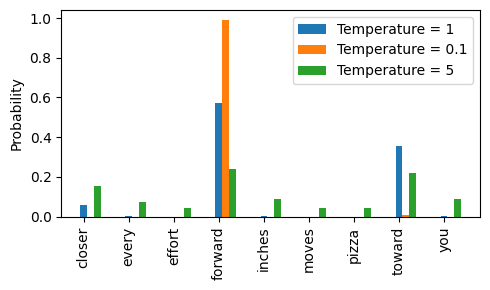

In [107]:
# @title simple test

import copy
import matplotlib.pyplot as plt

vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)
assert len(next_token_logits) == len(vocab)

def softmax_with_temperature(logits, temperature):
  logits = copy.deepcopy(logits)
  if temperature:
    assert temperature > 0, f"{temperature} MUST > 0"
    logits /= temperature
  return nn.functional.softmax(logits, dim=-1)

def sample_n_times(next_token_logits, n, temperature):
  counts = {}
  for _ in range(n):
    probas = softmax_with_temperature(next_token_logits, temperature)
    next_token_id = probas.multinomial(num_samples=1).item()
    next_text = inverse_vocab[next_token_id]
    if next_text in counts:
      counts[next_text] += 1
    else:
      counts[next_text] = 1
  return sorted([(k, v) for k, v in counts.items()], key=lambda x: x[1], reverse=True)

# When temp increases, it expects a more uniformed distribution.
for temperature in (0.1, 0.5, 1, 5, 10, 20):
  counts = sample_n_times(next_token_logits, 100, temperature)
  print(f"{temperature=}, {counts=}")

# Plot distribution @ different temp
temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T)
for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
  rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

## Top-K

When sampling, only sample among the top-k results. This helps to **avoid the very non-sense tokens** to be sampled.

It can be used together with the **temperature scaling**.

In [108]:
# @title simple test

def sample_n_times(next_token_logits, n, temperature, k):
  counts = {}
  for _ in range(n):
    top_logits, top_pos = torch.topk(next_token_logits, k)  # [B, K]
    top_k_logits = torch.where(
        condition=next_token_logits < top_logits[-1],
        input=torch.tensor(float('-inf')),
        other=next_token_logits
    )

    probas = softmax_with_temperature(next_token_logits, temperature)
    next_token_id = probas.multinomial(num_samples=1).item()
    next_text = inverse_vocab[next_token_id]
    if next_text in counts:
      counts[next_text] += 1
    else:
      counts[next_text] = 1
  return sorted([(k, v) for k, v in counts.items()], key=lambda x: x[1], reverse=True)

# When temp increases, it expects a more uniformed distribution.
for temperature in (0.1, 0.5, 1, 5, 10, 20):
  counts = sample_n_times(next_token_logits, 100, temperature, k=3)
  print(f"{temperature=}, {counts=}")

temperature=0.1, counts=[('forward', 98), ('toward', 2)]
temperature=0.5, counts=[('forward', 74), ('toward', 26)]
temperature=1, counts=[('forward', 53), ('toward', 39), ('closer', 6), ('effort', 1), ('inches', 1)]
temperature=5, counts=[('forward', 30), ('toward', 23), ('closer', 15), ('you', 12), ('pizza', 8), ('every', 5), ('inches', 4), ('effort', 3)]
temperature=10, counts=[('forward', 20), ('closer', 18), ('toward', 13), ('inches', 13), ('pizza', 10), ('you', 9), ('every', 8), ('moves', 5), ('effort', 4)]
temperature=20, counts=[('closer', 23), ('forward', 16), ('toward', 11), ('inches', 11), ('pizza', 9), ('effort', 9), ('you', 8), ('moves', 7), ('every', 6)]


## Combine temperature scaling and top-k

In [109]:
def generate(
    model, idx, max_new_tokens, context_size,
    temperature: float, top_k=1, eos_id=None) -> torch.Tensor:
  """Combined temperature scaling + top-k decoding."""
  model.eval()
  for i in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)    # [B, N, D_IN]
    logits = logits[:, -1, :] # [B, D_IN]

    # Top-k
    top_logits, top_pos = torch.topk(logits, top_k, dim=-1)  # [B, K]
    threshold = top_logits[:, -1].unsqueeze(dim=1)          # [B, 1]
    top_k_logits = torch.where(
        condition=(logits - threshold < 0),
        input=torch.tensor(float('-inf')),
        other=logits
    )

    # Temperature scaling
    probs = softmax_with_temperature(top_k_logits, temperature) # [B, D_IN]

    idx_next = probs.multinomial(num_samples=1) # [B, 1]

    idx = torch.cat([idx, idx_next.view(-1, 1)], -1)  # [B, D_IN + max_new_tokens]
    if eos_id and idx_next == eos_id:
      break

  model.train()
  return idx


In [110]:
# @title Test
torch.manual_seed(123)

idx = text_to_token_ids("Is Texas in USA?", tokenizer).to(device)
print(f"{idx.shape=}")
for _ in range(5):
  print("=" * 80)

  out = generate(
      gpt,
      idx,
      max_new_tokens=25,
      context_size=BASE_CONFIG["context_length"],
      temperature=1.5,
      top_k=50)

  print(token_ids_to_text(out[0, :].to('cpu'), tokenizer))


idx.shape=torch.Size([1, 5])
Is Texas in USA? as as the or,. very much ( the that., of. now
 an it ".; ( a one
Is Texas in USA? I) ' a, red little, their, and you if all with you was were,.ness that is only the
Is Texas in USA? the this they the this and way way you it, in-.)
- two a, which the s her its
Is Texas in USA? the. was a also, more first that much, a a to- but so of. who the same.ly.
Is Texas in USA? a that ' an- to first and she might much only,?, if (, this were this. the. the


In [111]:
# @title Another test

import copy
from tqdm import tqdm

def sample_resp(model,
                data: list[dict[str, str]] = test_data,
                n_examples: int = 3) -> list[dict[str, str]]:
  torch.manual_seed(123)

  n_examples = min(n_examples, len(data))
  ret = copy.deepcopy(data[:n_examples])


  for entry in tqdm(ret):
    text = format_input(entry, include_resp=False)
    correct_resp = entry["output"]
    tokens = text_to_token_ids(text, tokenizer).to(device)

    out = generate(
        model,
        tokens,
        max_new_tokens=100,
        context_size=BASE_CONFIG["context_length"],
        temperature=0.0,
        top_k=50,
        eos_id=50256)

    out_text = token_ids_to_text(out[0, :].to('cpu'), tokenizer)[len(text):].replace("### Response:", "").replace("<|endoftext|>", "").strip()
    entry["model_response"] = out_text
  return ret

def visualize_sampled_resp(data: list[dict[str, str]]):
  for entry in data:
    print("=" * 80)
    print("[ Input ]")
    print(format_input(entry, include_resp=False))
    print("[ Output ]")
    print(entry["model_response"])
    print("\n[ Correct Output ]")
    print(entry["output"])

samples = sample_resp(gpt)
visualize_sampled_resp(samples)


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

[ Input ]
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

[ Output ]
as as the,,. that the ( the.., of. now more an it are.; ( a. a) a a, a on, on, and other.,. the,.,. it that is only the the red and the little and or they are of, in-.) (- if a, the the they the its the. was a that, how first that much, a a.- ?. of. - the same. ".

[ Correct Output ]
The car is as fast as lightning.
[ Input ]
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

[ Output ]
a that ' an- new first and when on will only,.,, (ly this it.. the. the, more more the are a. a to. a. an the much a the, only are other of to ( was. of a-). (, -. will are only or the I. every the most if or and, and or. or for and are the such the in wit

# Loss metrics

## Quick check loss

In [112]:
torch.manual_seed(123)

for it in train_loader:
  input, target = it
  print(f"{inputs.shape=}")
  print(f"{targets.shape=}")

  with torch.no_grad():
    gpt.train()
    logits = gpt(inputs.to(device)) # [B, N, N_CLASS]
    gpt.eval()
  last_logit = logits[:, -1, :]     # [B, N_CLASS]
  last_target = target[:, -1]       # [B]

  loss = nn.functional.cross_entropy(last_logit, last_target)
  print(f"{loss=:.2f}, perplexity={torch.exp(loss)}")
  break

inputs.shape=torch.Size([8, 81])
targets.shape=torch.Size([8, 81])
loss=6.66, perplexity=778.92822265625


## More formal check of loss

In [113]:
from previous_chapters import (
    calc_loss_loader,
    calc_loss_batch,
)

torch.manual_seed(123)

with torch.no_grad():
  gpt.eval()
  train_loss = calc_loss_loader(train_loader, gpt, device, num_batches=5)
  val_loss = calc_loss_loader(val_loader, gpt, device, num_batches=5)
  gpt.train()

print(f"{train_loss=:.2f}")
print(f"{val_loss=:.2f}")

train_loss=8.10
val_loss=8.14


# Train

In [114]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.tok_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

## Training loop

In [115]:
import time
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(
    gpt.parameters(), lr=0.00005, weight_decay=0.1
)
num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    gpt, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 7.386, Val loss 7.376
Ep 1 (Step 000005): Train loss 6.210, Val loss 6.243
Ep 1 (Step 000010): Train loss 5.698, Val loss 5.671
Ep 1 (Step 000015): Train loss 5.236, Val loss 5.290
Ep 1 (Step 000020): Train loss 4.891, Val loss 5.012
Ep 1 (Step 000025): Train loss 4.643, Val loss 4.774
Ep 1 (Step 000030): Train loss 4.456, Val loss 4.498
Ep 1 (Step 000035): Train loss 4.261, Val loss 4.394
Ep 1 (Step 000040): Train loss 4.076, Val loss 4.122
Ep 1 (Step 000045): Train loss 4.005, Val loss 3.884
Ep 1 (Step 000050): Train loss 4.046, Val loss 3.868
Ep 1 (Step 000055): Train loss 3.803, Val loss 3.948
Ep 1 (Step 000060): Train loss 3.479, Val loss 3.575
Ep 1 (Step 000065): Train loss 3.264, Val loss 3.239
Ep 1 (Step 000070): Train loss 3.070, Val loss 3.191
Ep 1 (Step 000075): Train loss 2.979, Val loss 3.031
Ep 1 (Step 000080): Train loss 2.932, Val loss 2.900
Ep 1 (Step 000085): Train loss 2.859, Val loss 3.056
Ep 1 (Step 000090): Train loss 2.631, Val loss

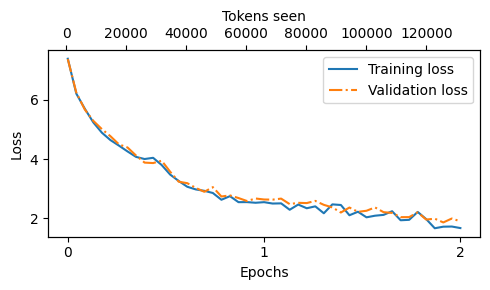

In [116]:
from previous_chapters import plot_losses
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [117]:
# Sample and visualize results
samples = sample_resp(gpt, n_examples=10)
visualize_sampled_resp(samples)

100%|██████████| 10/10 [00:02<00:00,  3.69it/s]

[ Input ]
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

[ Output ]
The very road was very lazy.

[ Correct Output ]
The car is as fast as lightning.
[ Input ]
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

[ Output ]
A storm is typically a storm typically.

My clouds, sky and mountains like Earth Tower, an sky.

[ Correct Output ]
The type of cloud typically associated with thunderstorms is cumulonimbus.
[ Input ]
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

[ Output ]
The theme of 'late' are Italian.'
2
The theme, which 'late, 'happy.

[ Correct Output ]
Jane Austen.
[ Input ]
Be

## Save loaded model weights

In [118]:
import re

file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(gpt.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as ropegpt2-small124M-sft.pth


# Eval

Note, the section is not finished. The original instruction uses LLAMA3 as an autorater to give rating.

## Save eval results

In [119]:
samples = sample_resp(gpt, n_examples=10000000)

100%|██████████| 110/110 [00:31<00:00,  3.49it/s]


In [120]:
with open("instruction-data-with-response.json", "w") as file:
  json.dump(samples, file, indent=4)

with open("instruction-data-with-response.json", "r") as file:
  loaded_samples = json.load(file)
  assert len(loaded_samples) == len(samples)
  assert loaded_samples[0] == samples[0]
  pprint.pprint(loaded_samples[0])

{'input': 'The car is very fast.',
 'instruction': 'Rewrite the sentence using a simile.',
 'model_response': 'The very road was very lazy.',
 'output': 'The car is as fast as lightning.'}


## Run LLAMA3 locally

- This uses Ollama library, which is a c++ impl for inference engine.
- Note this section is not finished, since the Ollama needs a local workstation to run.

In [121]:
# @title Install Ollama

# This is needed to detect GPU in colab env.
!sudo apt-get install -y pciutils

! curl https://ollama.ai/install.sh | sh

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpci3 pci.ids
The following NEW packages will be installed:
  libpci3 pci.ids pciutils
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 343 kB of archives.
After this operation, 1,581 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 pci.ids all 0.0~2022.01.22-1ubuntu0.1 [251 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libpci3 amd64 1:3.7.0-6 [28.9 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 pciutils amd64 1:3.7.0-6 [63.6 kB]
Fetched 343 kB in 0s (1,759 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 3.)
debconf: falling back to frontend: Readline
debconf: 

In [122]:
# @title Libs

import os
import psutil
import threading
import subprocess
import requests
import json

def run_ollama_in_subprocess():
  os.environ['OLLAMA_HOST'] = '0.0.0.0:11434'
  os.environ['OLLAMA_ORIGINS'] = '*'
  subprocess.Popen(["ollama", "serve"])



def check_if_running(process_name):
  running = False
  for proc in psutil.process_iter(["name"]):
    if process_name in proc.info["name"]:
      running = True
      break
  return running



In [125]:
# @title Run Ollama with the llama3 model

# Starting Ollama server
ollama_thread = threading.Thread(target=run_ollama_in_subprocess)
ollama_thread.start()
ollama_running = check_if_running("ollama")

i = 0
while True:
  if check_if_running("ollama"):
    break
  else:
    if i == 10:
      raise RuntimeError(
          "Ollama not running. Launch ollama before proceeding."
      )
    else:
      time.sleep(2)

# Download model
!ollama pull llama3

In [126]:
prompt = """
What is AI?
Can you explain in three paragraphs?
"""

def query_ollama(prompt, model: str = "llama3") -> str:
  url = 'http://localhost:11434/api/chat'
  payload = {
      "model": model,
      "temperature": 0.6,
      "stream": False,
      "seed": 123,
      "num_ctx": 2048,
      "messages": [
          {"role": "system", "content": "You are an AI assistant!"},
          {"role": "user", "content": prompt}
      ]
  }

  response = requests.post(url, json=payload)
  message_str = response.content.decode('utf-8')
  message_dict = json.loads(message_str)
  print(message_dict)
  return message_dict['message']['content']

query_ollama(prompt, model="llama3")

{'model': 'llama3', 'created_at': '2025-05-16T21:54:25.18422201Z', 'message': {'role': 'assistant', 'content': "I'd be happy to explain what AI is!\n\nArtificial Intelligence, or AI, refers to the development of computer systems that can perform tasks that would typically require human intelligence. This includes things like visual perception, speech recognition, decision-making, and problem-solving. In other words, AI allows computers to think and learn like humans do, but without the need for human intervention. AI is not just limited to simple tasks like sorting data or performing arithmetic operations; it can also be used to create more complex systems that can interact with their environment, make decisions based on incomplete information, and even exhibit some degree of creativity.\n\nOne of the key features of AI is its ability to learn from experience. This is often referred to as machine learning, where computers are trained on large datasets or fed a series of examples to hel

"I'd be happy to explain what AI is!\n\nArtificial Intelligence, or AI, refers to the development of computer systems that can perform tasks that would typically require human intelligence. This includes things like visual perception, speech recognition, decision-making, and problem-solving. In other words, AI allows computers to think and learn like humans do, but without the need for human intervention. AI is not just limited to simple tasks like sorting data or performing arithmetic operations; it can also be used to create more complex systems that can interact with their environment, make decisions based on incomplete information, and even exhibit some degree of creativity.\n\nOne of the key features of AI is its ability to learn from experience. This is often referred to as machine learning, where computers are trained on large datasets or fed a series of examples to help them recognize patterns and relationships. As the computer processes more data, it can refine its understandi

In [ ]:
loaded_samples[0]

In [127]:
# @title Test autorater

for entry in loaded_samples[:3]:
  prompt = (
      f"Given the input `{format_input(entry)}` "
      f"and correct output `{entry['output']}`, "
      f"score the model response `{entry['model_response']}`"
      f" on a scale from 0 to 100, where 100 is the best score. "
  )
  print("\nDataset response:")
  print(">>", entry['output'])
  print("\nModel response:")
  print(">>", entry["model_response"])
  print("\nScore:")
  print(">>", query_ollama(prompt))
  print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The very road was very lazy.

Score:
{'model': 'llama3', 'created_at': '2025-05-16T21:54:29.332368215Z', 'message': {'role': 'assistant', 'content': "I'd be happy to help!\n\nTo evaluate the model's response, I'll compare it to the original input and the correct output.\n\nOriginal input: The car is very fast.\nCorrect output: The car is as fast as lightning.\n\nModel's response: The very road was very lazy.\n\nComparison:\n\n* The model's response does not complete the instruction to rewrite the sentence using a simile, which was to compare the car's speed to something else (e.g., another car, an animal, etc.).\n* The response is unrelated to the original input and does not convey any information about the car's speed.\n\nScore: 0\n\nThe model's response does not meet the requirements of the instruction, making it a poor score."}, 'done_reason': 'stop', 'done': True, 'total_duration': 4077951493, 'load_duration

In [128]:
def generate_model_scores(json_data, json_key, model="llama3"):
  scores = []
  for entry in tqdm(json_data, desc="Scoring entries"):
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry[json_key]}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
        f"Respond with the integer number only."
    )
    try:
      score = query_ollama(prompt, model)
      scores.append(int(score))
    except ValueError:
      print(f"Could not convert score: {score}")
      continue
  return scores

In [129]:
scores = generate_model_scores(loaded_samples, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries:   2%|▏         | 2/110 [00:00<00:16,  6.42it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:34.121285375Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 139985441, 'load_duration': 22221641, 'prompt_eval_count': 126, 'prompt_eval_duration': 20634573, 'eval_count': 2, 'eval_duration': 96150993}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:34.28555714Z', 'message': {'role': 'assistant', 'content': '10'}, 'done_reason': 'stop', 'done': True, 'total_duration': 159229100, 'load_duration': 25603133, 'prompt_eval_count': 147, 'prompt_eval_duration': 23753049, 'eval_count': 2, 'eval_duration': 108471007}


Scoring entries:   4%|▎         | 4/110 [00:00<00:16,  6.24it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:34.451894918Z', 'message': {'role': 'assistant', 'content': '2'}, 'done_reason': 'stop', 'done': True, 'total_duration': 159762373, 'load_duration': 41029497, 'prompt_eval_count': 126, 'prompt_eval_duration': 20064956, 'eval_count': 2, 'eval_duration': 97574209}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:34.61159285Z', 'message': {'role': 'assistant', 'content': '0'}, 'done_reason': 'stop', 'done': True, 'total_duration': 155273953, 'load_duration': 40771249, 'prompt_eval_count': 115, 'prompt_eval_duration': 22535049, 'eval_count': 2, 'eval_duration': 90955545}


Scoring entries:   5%|▌         | 6/110 [00:00<00:16,  6.14it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:34.777806275Z', 'message': {'role': 'assistant', 'content': '95'}, 'done_reason': 'stop', 'done': True, 'total_duration': 159690214, 'load_duration': 39309293, 'prompt_eval_count': 129, 'prompt_eval_duration': 20559247, 'eval_count': 2, 'eval_duration': 98567978}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:34.941631475Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 156413719, 'load_duration': 42917488, 'prompt_eval_count': 114, 'prompt_eval_duration': 18830194, 'eval_count': 2, 'eval_duration': 93755659}


Scoring entries:   7%|▋         | 8/110 [00:01<00:17,  5.96it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:35.113836701Z', 'message': {'role': 'assistant', 'content': '60'}, 'done_reason': 'stop', 'done': True, 'total_duration': 168264173, 'load_duration': 50204253, 'prompt_eval_count': 126, 'prompt_eval_duration': 20386103, 'eval_count': 2, 'eval_duration': 96627093}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:35.285423057Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 165170861, 'load_duration': 43858394, 'prompt_eval_count': 132, 'prompt_eval_duration': 20716328, 'eval_count': 2, 'eval_duration': 99606211}


Scoring entries:   9%|▉         | 10/110 [00:01<00:17,  5.73it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:35.470110458Z', 'message': {'role': 'assistant', 'content': '67'}, 'done_reason': 'stop', 'done': True, 'total_duration': 178499602, 'load_duration': 40887592, 'prompt_eval_count': 143, 'prompt_eval_duration': 27439753, 'eval_count': 2, 'eval_duration': 108873769}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:35.64799584Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 172096728, 'load_duration': 41149537, 'prompt_eval_count': 146, 'prompt_eval_duration': 23006448, 'eval_count': 2, 'eval_duration': 106923326}


Scoring entries:  11%|█         | 12/110 [00:02<00:17,  5.72it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:35.811687347Z', 'message': {'role': 'assistant', 'content': '25'}, 'done_reason': 'stop', 'done': True, 'total_duration': 157374684, 'load_duration': 35924282, 'prompt_eval_count': 124, 'prompt_eval_duration': 23761719, 'eval_count': 2, 'eval_duration': 96645154}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:35.994294873Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 176059600, 'load_duration': 38832476, 'prompt_eval_count': 146, 'prompt_eval_duration': 29755530, 'eval_count': 2, 'eval_duration': 105995714}


Scoring entries:  13%|█▎        | 14/110 [00:02<00:16,  5.96it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:36.162898137Z', 'message': {'role': 'assistant', 'content': '89'}, 'done_reason': 'stop', 'done': True, 'total_duration': 162361871, 'load_duration': 44270531, 'prompt_eval_count': 125, 'prompt_eval_duration': 20296450, 'eval_count': 2, 'eval_duration': 96686029}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:36.319499711Z', 'message': {'role': 'assistant', 'content': '60'}, 'done_reason': 'stop', 'done': True, 'total_duration': 151398089, 'load_duration': 37945118, 'prompt_eval_count': 113, 'prompt_eval_duration': 23009826, 'eval_count': 2, 'eval_duration': 89493014}


Scoring entries:  15%|█▍        | 16/110 [00:02<00:17,  5.37it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:36.575252525Z', 'message': {'role': 'assistant', 'content': '0'}, 'done_reason': 'stop', 'done': True, 'total_duration': 250993445, 'load_duration': 35555319, 'prompt_eval_count': 202, 'prompt_eval_duration': 44258787, 'eval_count': 2, 'eval_duration': 169812807}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:36.743028677Z', 'message': {'role': 'assistant', 'content': '100'}, 'done_reason': 'stop', 'done': True, 'total_duration': 162633967, 'load_duration': 42185823, 'prompt_eval_count': 136, 'prompt_eval_duration': 21071189, 'eval_count': 2, 'eval_duration': 98247402}


Scoring entries:  16%|█▋        | 18/110 [00:03<00:15,  6.01it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:36.884779606Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 137451242, 'load_duration': 21736728, 'prompt_eval_count': 123, 'prompt_eval_duration': 21057968, 'eval_count': 2, 'eval_duration': 93826228}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:37.036668431Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 148149931, 'load_duration': 23786269, 'prompt_eval_count': 125, 'prompt_eval_duration': 27110011, 'eval_count': 2, 'eval_duration': 96230437}


Scoring entries:  18%|█▊        | 20/110 [00:03<00:14,  6.24it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:37.195460197Z', 'message': {'role': 'assistant', 'content': '90'}, 'done_reason': 'stop', 'done': True, 'total_duration': 154891382, 'load_duration': 21932423, 'prompt_eval_count': 137, 'prompt_eval_duration': 32851087, 'eval_count': 2, 'eval_duration': 99089618}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:37.346275881Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 146815271, 'load_duration': 22449650, 'prompt_eval_count': 131, 'prompt_eval_duration': 24355532, 'eval_count': 2, 'eval_duration': 97748985}


Scoring entries:  20%|██        | 22/110 [00:03<00:13,  6.53it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:37.491325708Z', 'message': {'role': 'assistant', 'content': '98'}, 'done_reason': 'stop', 'done': True, 'total_duration': 141105425, 'load_duration': 21834704, 'prompt_eval_count': 130, 'prompt_eval_duration': 21297719, 'eval_count': 2, 'eval_duration': 97136421}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:37.638589931Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 143338729, 'load_duration': 21809047, 'prompt_eval_count': 130, 'prompt_eval_duration': 23719615, 'eval_count': 2, 'eval_duration': 96960882}


Scoring entries:  22%|██▏       | 24/110 [00:03<00:13,  6.35it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:37.79514271Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 152127196, 'load_duration': 22233779, 'prompt_eval_count': 143, 'prompt_eval_duration': 23646782, 'eval_count': 2, 'eval_duration': 105248962}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:37.960772456Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 161833698, 'load_duration': 22944886, 'prompt_eval_count': 139, 'prompt_eval_duration': 34081602, 'eval_count': 2, 'eval_duration': 103901717}


Scoring entries:  24%|██▎       | 26/110 [00:04<00:13,  6.06it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:38.116965862Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 152479045, 'load_duration': 24126204, 'prompt_eval_count': 130, 'prompt_eval_duration': 27780428, 'eval_count': 2, 'eval_duration': 99587426}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:38.300390651Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 177521536, 'load_duration': 36232014, 'prompt_eval_count': 150, 'prompt_eval_duration': 33426138, 'eval_count': 2, 'eval_duration': 106768632}


Scoring entries:  25%|██▌       | 28/110 [00:04<00:13,  6.22it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:38.449172083Z', 'message': {'role': 'assistant', 'content': '15'}, 'done_reason': 'stop', 'done': True, 'total_duration': 144618102, 'load_duration': 24431730, 'prompt_eval_count': 125, 'prompt_eval_duration': 23497242, 'eval_count': 2, 'eval_duration': 95573544}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:38.611031892Z', 'message': {'role': 'assistant', 'content': '0'}, 'done_reason': 'stop', 'done': True, 'total_duration': 157895795, 'load_duration': 24250606, 'prompt_eval_count': 142, 'prompt_eval_duration': 26917610, 'eval_count': 2, 'eval_duration': 105713919}


Scoring entries:  27%|██▋       | 30/110 [00:04<00:12,  6.32it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:38.772171566Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 156752970, 'load_duration': 21721163, 'prompt_eval_count': 143, 'prompt_eval_duration': 26684384, 'eval_count': 2, 'eval_duration': 105706763}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:38.924386931Z', 'message': {'role': 'assistant', 'content': '25'}, 'done_reason': 'stop', 'done': True, 'total_duration': 147136457, 'load_duration': 22442410, 'prompt_eval_count': 132, 'prompt_eval_duration': 24759648, 'eval_count': 2, 'eval_duration': 98979325}


Scoring entries:  29%|██▉       | 32/110 [00:05<00:11,  6.50it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:39.077338738Z', 'message': {'role': 'assistant', 'content': '25'}, 'done_reason': 'stop', 'done': True, 'total_duration': 149359773, 'load_duration': 23145340, 'prompt_eval_count': 124, 'prompt_eval_duration': 28042524, 'eval_count': 2, 'eval_duration': 96295785}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:39.224486406Z', 'message': {'role': 'assistant', 'content': '65'}, 'done_reason': 'stop', 'done': True, 'total_duration': 142923560, 'load_duration': 25639080, 'prompt_eval_count': 122, 'prompt_eval_duration': 20878950, 'eval_count': 2, 'eval_duration': 95419389}


Scoring entries:  31%|███       | 34/110 [00:05<00:11,  6.55it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:39.382624413Z', 'message': {'role': 'assistant', 'content': '10'}, 'done_reason': 'stop', 'done': True, 'total_duration': 153878706, 'load_duration': 22306192, 'prompt_eval_count': 149, 'prompt_eval_duration': 23679134, 'eval_count': 2, 'eval_duration': 106807752}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:39.529534586Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 140607562, 'load_duration': 22000326, 'prompt_eval_count': 129, 'prompt_eval_duration': 20880783, 'eval_count': 2, 'eval_duration': 96776706}


Scoring entries:  33%|███▎      | 36/110 [00:05<00:11,  6.67it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:39.673498208Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 139326605, 'load_duration': 21866582, 'prompt_eval_count': 124, 'prompt_eval_duration': 20637512, 'eval_count': 2, 'eval_duration': 95948074}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:39.823241945Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 146106924, 'load_duration': 23189014, 'prompt_eval_count': 138, 'prompt_eval_duration': 24480402, 'eval_count': 2, 'eval_duration': 97257345}


Scoring entries:  35%|███▍      | 38/110 [00:06<00:10,  6.77it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:39.967698098Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 140572179, 'load_duration': 22701335, 'prompt_eval_count': 126, 'prompt_eval_duration': 21191107, 'eval_count': 2, 'eval_duration': 95627993}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:40.114478995Z', 'message': {'role': 'assistant', 'content': '75'}, 'done_reason': 'stop', 'done': True, 'total_duration': 142778655, 'load_duration': 23066469, 'prompt_eval_count': 129, 'prompt_eval_duration': 21310167, 'eval_count': 2, 'eval_duration': 97464219}


Scoring entries:  36%|███▋      | 40/110 [00:06<00:10,  6.51it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:40.261519261Z', 'message': {'role': 'assistant', 'content': '60'}, 'done_reason': 'stop', 'done': True, 'total_duration': 143201170, 'load_duration': 22285275, 'prompt_eval_count': 133, 'prompt_eval_duration': 21336611, 'eval_count': 2, 'eval_duration': 98657808}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:40.429122623Z', 'message': {'role': 'assistant', 'content': '0'}, 'done_reason': 'stop', 'done': True, 'total_duration': 163776180, 'load_duration': 24390214, 'prompt_eval_count': 156, 'prompt_eval_duration': 26192846, 'eval_count': 2, 'eval_duration': 112120506}


Scoring entries:  38%|███▊      | 42/110 [00:06<00:10,  6.62it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:40.576040282Z', 'message': {'role': 'assistant', 'content': '0'}, 'done_reason': 'stop', 'done': True, 'total_duration': 142285966, 'load_duration': 22528654, 'prompt_eval_count': 125, 'prompt_eval_duration': 21470663, 'eval_count': 2, 'eval_duration': 96825793}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:40.725718936Z', 'message': {'role': 'assistant', 'content': '10'}, 'done_reason': 'stop', 'done': True, 'total_duration': 144515431, 'load_duration': 22215555, 'prompt_eval_count': 135, 'prompt_eval_duration': 22838951, 'eval_count': 2, 'eval_duration': 98444847}


Scoring entries:  40%|████      | 44/110 [00:07<00:10,  6.54it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:40.889440015Z', 'message': {'role': 'assistant', 'content': '90'}, 'done_reason': 'stop', 'done': True, 'total_duration': 159120356, 'load_duration': 22197248, 'prompt_eval_count': 144, 'prompt_eval_duration': 29945956, 'eval_count': 2, 'eval_duration': 105831175}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:41.038394546Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 144727217, 'load_duration': 22720288, 'prompt_eval_count': 130, 'prompt_eval_duration': 23981328, 'eval_count': 2, 'eval_duration': 97097252}


Scoring entries:  42%|████▏     | 46/110 [00:07<00:09,  6.65it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:41.184103554Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 142143506, 'load_duration': 22816282, 'prompt_eval_count': 131, 'prompt_eval_duration': 21294082, 'eval_count': 2, 'eval_duration': 97157447}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:41.333305654Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 145932567, 'load_duration': 25415345, 'prompt_eval_count': 132, 'prompt_eval_duration': 21118254, 'eval_count': 2, 'eval_duration': 98010593}


Scoring entries:  44%|████▎     | 48/110 [00:07<00:09,  6.70it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:41.490126051Z', 'message': {'role': 'assistant', 'content': '60'}, 'done_reason': 'stop', 'done': True, 'total_duration': 152582396, 'load_duration': 21835034, 'prompt_eval_count': 140, 'prompt_eval_duration': 23406300, 'eval_count': 2, 'eval_duration': 106484373}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:41.632462955Z', 'message': {'role': 'assistant', 'content': '92'}, 'done_reason': 'stop', 'done': True, 'total_duration': 138200082, 'load_duration': 26471483, 'prompt_eval_count': 117, 'prompt_eval_duration': 19485986, 'eval_count': 2, 'eval_duration': 91243538}


Scoring entries:  45%|████▌     | 50/110 [00:07<00:08,  6.86it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:41.782496908Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 146076566, 'load_duration': 23506479, 'prompt_eval_count': 130, 'prompt_eval_duration': 24530502, 'eval_count': 2, 'eval_duration': 97129650}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:41.919574789Z', 'message': {'role': 'assistant', 'content': '68'}, 'done_reason': 'stop', 'done': True, 'total_duration': 133752387, 'load_duration': 22620724, 'prompt_eval_count': 114, 'prompt_eval_duration': 19775684, 'eval_count': 2, 'eval_duration': 90403628}


Scoring entries:  47%|████▋     | 52/110 [00:08<00:08,  7.03it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:42.061415672Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 138493445, 'load_duration': 24875866, 'prompt_eval_count': 119, 'prompt_eval_duration': 24419275, 'eval_count': 2, 'eval_duration': 88394625}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:42.198085313Z', 'message': {'role': 'assistant', 'content': '90'}, 'done_reason': 'stop', 'done': True, 'total_duration': 132895481, 'load_duration': 24076245, 'prompt_eval_count': 117, 'prompt_eval_duration': 19306499, 'eval_count': 2, 'eval_duration': 88644266}


Scoring entries:  49%|████▉     | 54/110 [00:08<00:08,  6.56it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:42.351721445Z', 'message': {'role': 'assistant', 'content': '100'}, 'done_reason': 'stop', 'done': True, 'total_duration': 149659350, 'load_duration': 22731566, 'prompt_eval_count': 131, 'prompt_eval_duration': 29189199, 'eval_count': 2, 'eval_duration': 96840766}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:42.520406897Z', 'message': {'role': 'assistant', 'content': '0'}, 'done_reason': 'stop', 'done': True, 'total_duration': 164006328, 'load_duration': 21838406, 'prompt_eval_count': 166, 'prompt_eval_duration': 26216814, 'eval_count': 2, 'eval_duration': 114958553}


Scoring entries:  51%|█████     | 56/110 [00:08<00:08,  6.43it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:42.663342595Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 138804525, 'load_duration': 22001166, 'prompt_eval_count': 127, 'prompt_eval_duration': 20697756, 'eval_count': 2, 'eval_duration': 95159886}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:42.832999441Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 165491855, 'load_duration': 24733954, 'prompt_eval_count': 164, 'prompt_eval_duration': 25892851, 'eval_count': 2, 'eval_duration': 113575257}


Scoring entries:  53%|█████▎    | 58/110 [00:09<00:07,  6.74it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:42.984888776Z', 'message': {'role': 'assistant', 'content': '90'}, 'done_reason': 'stop', 'done': True, 'total_duration': 147523304, 'load_duration': 23711224, 'prompt_eval_count': 130, 'prompt_eval_duration': 21556462, 'eval_count': 2, 'eval_duration': 101375400}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:43.118766726Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 129706489, 'load_duration': 21834130, 'prompt_eval_count': 116, 'prompt_eval_duration': 19175656, 'eval_count': 2, 'eval_duration': 87882369}


Scoring entries:  55%|█████▍    | 60/110 [00:09<00:07,  6.89it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:43.255118824Z', 'message': {'role': 'assistant', 'content': '0'}, 'done_reason': 'stop', 'done': True, 'total_duration': 132408541, 'load_duration': 21733900, 'prompt_eval_count': 121, 'prompt_eval_duration': 20334465, 'eval_count': 2, 'eval_duration': 89449839}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:43.40164174Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 142591057, 'load_duration': 30749518, 'prompt_eval_count': 115, 'prompt_eval_duration': 22099128, 'eval_count': 2, 'eval_duration': 88661033}


Scoring entries:  56%|█████▋    | 62/110 [00:09<00:06,  6.92it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:43.537629092Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 132308851, 'load_duration': 22155382, 'prompt_eval_count': 112, 'prompt_eval_duration': 19880174, 'eval_count': 2, 'eval_duration': 87961571}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:43.687155844Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 145601123, 'load_duration': 22565643, 'prompt_eval_count': 133, 'prompt_eval_duration': 24923098, 'eval_count': 2, 'eval_duration': 97167274}


Scoring entries:  58%|█████▊    | 64/110 [00:10<00:06,  6.92it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:43.842961498Z', 'message': {'role': 'assistant', 'content': '12'}, 'done_reason': 'stop', 'done': True, 'total_duration': 152126253, 'load_duration': 21685528, 'prompt_eval_count': 133, 'prompt_eval_duration': 31481135, 'eval_count': 2, 'eval_duration': 98037128}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:43.979917445Z', 'message': {'role': 'assistant', 'content': '50'}, 'done_reason': 'stop', 'done': True, 'total_duration': 132440160, 'load_duration': 22515663, 'prompt_eval_count': 124, 'prompt_eval_duration': 19516940, 'eval_count': 2, 'eval_duration': 89541580}


Scoring entries:  59%|█████▉    | 65/110 [00:10<00:06,  6.89it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:44.126023452Z', 'message': {'role': 'assistant', 'content': '40'}, 'done_reason': 'stop', 'done': True, 'total_duration': 142510915, 'load_duration': 21865444, 'prompt_eval_count': 139, 'prompt_eval_duration': 21542351, 'eval_count': 2, 'eval_duration': 98099274}


Scoring entries:  61%|██████    | 67/110 [00:10<00:06,  6.30it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:44.345613873Z', 'message': {'role': 'assistant', 'content': '2'}, 'done_reason': 'stop', 'done': True, 'total_duration': 216019867, 'load_duration': 28084622, 'prompt_eval_count': 170, 'prompt_eval_duration': 33954000, 'eval_count': 2, 'eval_duration': 152784986}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:44.484173322Z', 'message': {'role': 'assistant', 'content': '87'}, 'done_reason': 'stop', 'done': True, 'total_duration': 134733242, 'load_duration': 21996396, 'prompt_eval_count': 121, 'prompt_eval_duration': 22182232, 'eval_count': 2, 'eval_duration': 89738103}


Scoring entries:  63%|██████▎   | 69/110 [00:10<00:06,  6.44it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:44.62887044Z', 'message': {'role': 'assistant', 'content': '78'}, 'done_reason': 'stop', 'done': True, 'total_duration': 140638423, 'load_duration': 21738337, 'prompt_eval_count': 129, 'prompt_eval_duration': 21090150, 'eval_count': 2, 'eval_duration': 96961764}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:44.78531241Z', 'message': {'role': 'assistant', 'content': '90'}, 'done_reason': 'stop', 'done': True, 'total_duration': 152532754, 'load_duration': 21929659, 'prompt_eval_count': 136, 'prompt_eval_duration': 30963877, 'eval_count': 2, 'eval_duration': 98773895}


Scoring entries:  65%|██████▍   | 71/110 [00:11<00:05,  6.66it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:44.931126939Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 142084758, 'load_duration': 22934918, 'prompt_eval_count': 129, 'prompt_eval_duration': 21120268, 'eval_count': 2, 'eval_duration': 97149582}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:45.075883558Z', 'message': {'role': 'assistant', 'content': '95'}, 'done_reason': 'stop', 'done': True, 'total_duration': 140514344, 'load_duration': 22338167, 'prompt_eval_count': 123, 'prompt_eval_duration': 20457814, 'eval_count': 2, 'eval_duration': 94543904}


Scoring entries:  66%|██████▋   | 73/110 [00:11<00:05,  6.32it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:45.233745914Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 153880972, 'load_duration': 24302161, 'prompt_eval_count': 139, 'prompt_eval_duration': 23428151, 'eval_count': 2, 'eval_duration': 105250740}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:45.405353836Z', 'message': {'role': 'assistant', 'content': '40'}, 'done_reason': 'stop', 'done': True, 'total_duration': 167344538, 'load_duration': 22152387, 'prompt_eval_count': 166, 'prompt_eval_duration': 29481343, 'eval_count': 2, 'eval_duration': 114705844}


Scoring entries:  68%|██████▊   | 75/110 [00:11<00:05,  6.51it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:45.545348846Z', 'message': {'role': 'assistant', 'content': '1'}, 'done_reason': 'stop', 'done': True, 'total_duration': 136060443, 'load_duration': 22643786, 'prompt_eval_count': 114, 'prompt_eval_duration': 23302964, 'eval_count': 2, 'eval_duration': 89065131}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:45.70130319Z', 'message': {'role': 'assistant', 'content': '100'}, 'done_reason': 'stop', 'done': True, 'total_duration': 151670124, 'load_duration': 22108394, 'prompt_eval_count': 138, 'prompt_eval_duration': 23686082, 'eval_count': 2, 'eval_duration': 105025762}


Scoring entries:  70%|███████   | 77/110 [00:12<00:04,  6.70it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:45.848013478Z', 'message': {'role': 'assistant', 'content': '92'}, 'done_reason': 'stop', 'done': True, 'total_duration': 142446943, 'load_duration': 23537437, 'prompt_eval_count': 127, 'prompt_eval_duration': 20721379, 'eval_count': 2, 'eval_duration': 96813863}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:45.991689495Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 139558613, 'load_duration': 22551016, 'prompt_eval_count': 125, 'prompt_eval_duration': 20902796, 'eval_count': 2, 'eval_duration': 95260372}


Scoring entries:  72%|███████▏  | 79/110 [00:12<00:04,  6.37it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:46.170435275Z', 'message': {'role': 'assistant', 'content': '72'}, 'done_reason': 'stop', 'done': True, 'total_duration': 174709891, 'load_duration': 22647941, 'prompt_eval_count': 158, 'prompt_eval_duration': 36848502, 'eval_count': 2, 'eval_duration': 114106605}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:46.325267631Z', 'message': {'role': 'assistant', 'content': '15'}, 'done_reason': 'stop', 'done': True, 'total_duration': 151215441, 'load_duration': 21901104, 'prompt_eval_count': 145, 'prompt_eval_duration': 23557674, 'eval_count': 2, 'eval_duration': 104820014}


Scoring entries:  74%|███████▎  | 81/110 [00:12<00:04,  6.52it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:46.475872498Z', 'message': {'role': 'assistant', 'content': '90'}, 'done_reason': 'stop', 'done': True, 'total_duration': 146464006, 'load_duration': 24388595, 'prompt_eval_count': 131, 'prompt_eval_duration': 24234080, 'eval_count': 2, 'eval_duration': 96966139}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:46.624980617Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 145606788, 'load_duration': 23771749, 'prompt_eval_count': 135, 'prompt_eval_duration': 21747114, 'eval_count': 2, 'eval_duration': 98169821}


Scoring entries:  75%|███████▍  | 82/110 [00:12<00:04,  6.62it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:46.77078346Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 141855471, 'load_duration': 22777791, 'prompt_eval_count': 127, 'prompt_eval_duration': 20721711, 'eval_count': 2, 'eval_duration': 97435618}


Scoring entries:  76%|███████▋  | 84/110 [00:13<00:04,  5.84it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:47.009241981Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 233378327, 'load_duration': 38081940, 'prompt_eval_count': 172, 'prompt_eval_duration': 35205660, 'eval_count': 2, 'eval_duration': 158886830}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:47.165899401Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 151190849, 'load_duration': 37196730, 'prompt_eval_count': 117, 'prompt_eval_duration': 22286434, 'eval_count': 2, 'eval_duration': 90717054}


Scoring entries:  78%|███████▊  | 86/110 [00:13<00:04,  5.82it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:47.338001078Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 168013425, 'load_duration': 40265921, 'prompt_eval_count': 131, 'prompt_eval_duration': 26268719, 'eval_count': 2, 'eval_duration': 98758543}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:47.510723165Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 164510752, 'load_duration': 43143957, 'prompt_eval_count': 132, 'prompt_eval_duration': 21018498, 'eval_count': 2, 'eval_duration': 99323359}


Scoring entries:  80%|████████  | 88/110 [00:13<00:03,  5.86it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:47.665978623Z', 'message': {'role': 'assistant', 'content': '87'}, 'done_reason': 'stop', 'done': True, 'total_duration': 148379796, 'load_duration': 37312540, 'prompt_eval_count': 119, 'prompt_eval_duration': 19293955, 'eval_count': 2, 'eval_duration': 90125141}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:47.846058513Z', 'message': {'role': 'assistant', 'content': '2'}, 'done_reason': 'stop', 'done': True, 'total_duration': 175481672, 'load_duration': 38677307, 'prompt_eval_count': 142, 'prompt_eval_duration': 22836341, 'eval_count': 2, 'eval_duration': 113025212}


Scoring entries:  82%|████████▏ | 90/110 [00:14<00:03,  5.89it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:48.036330208Z', 'message': {'role': 'assistant', 'content': '5'}, 'done_reason': 'stop', 'done': True, 'total_duration': 185951950, 'load_duration': 38621749, 'prompt_eval_count': 164, 'prompt_eval_duration': 29101382, 'eval_count': 2, 'eval_duration': 117110705}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:48.19024264Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 149721895, 'load_duration': 39509416, 'prompt_eval_count': 118, 'prompt_eval_duration': 18991022, 'eval_count': 2, 'eval_duration': 90344161}


Scoring entries:  84%|████████▎ | 92/110 [00:14<00:03,  5.98it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:48.355612164Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 161338328, 'load_duration': 42170344, 'prompt_eval_count': 123, 'prompt_eval_duration': 20065652, 'eval_count': 2, 'eval_duration': 98178688}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:48.519131775Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 159569634, 'load_duration': 36316012, 'prompt_eval_count': 137, 'prompt_eval_duration': 21011907, 'eval_count': 2, 'eval_duration': 100594686}


Scoring entries:  85%|████████▌ | 94/110 [00:14<00:02,  5.67it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:48.685491635Z', 'message': {'role': 'assistant', 'content': '92'}, 'done_reason': 'stop', 'done': True, 'total_duration': 160522657, 'load_duration': 37830657, 'prompt_eval_count': 134, 'prompt_eval_duration': 21397402, 'eval_count': 2, 'eval_duration': 99928285}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:48.883906513Z', 'message': {'role': 'assistant', 'content': '0'}, 'done_reason': 'stop', 'done': True, 'total_duration': 194308999, 'load_duration': 50545585, 'prompt_eval_count': 156, 'prompt_eval_duration': 27192189, 'eval_count': 2, 'eval_duration': 114952543}


Scoring entries:  87%|████████▋ | 96/110 [00:15<00:02,  5.75it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:49.056204912Z', 'message': {'role': 'assistant', 'content': '40'}, 'done_reason': 'stop', 'done': True, 'total_duration': 167209904, 'load_duration': 41499587, 'prompt_eval_count': 135, 'prompt_eval_duration': 25123096, 'eval_count': 2, 'eval_duration': 99501685}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:49.227345379Z', 'message': {'role': 'assistant', 'content': '0'}, 'done_reason': 'stop', 'done': True, 'total_duration': 166109475, 'load_duration': 39339438, 'prompt_eval_count': 133, 'prompt_eval_duration': 24436131, 'eval_count': 2, 'eval_duration': 99601796}


Scoring entries:  89%|████████▉ | 98/110 [00:15<00:02,  5.96it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:49.402009876Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 169633039, 'load_duration': 35974031, 'prompt_eval_count': 144, 'prompt_eval_duration': 23581454, 'eval_count': 2, 'eval_duration': 108877878}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:49.555760175Z', 'message': {'role': 'assistant', 'content': '0'}, 'done_reason': 'stop', 'done': True, 'total_duration': 148978803, 'load_duration': 40206583, 'prompt_eval_count': 113, 'prompt_eval_duration': 18674483, 'eval_count': 2, 'eval_duration': 89130773}


Scoring entries:  91%|█████████ | 100/110 [00:15<00:01,  6.19it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:49.71447824Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 154686282, 'load_duration': 25702830, 'prompt_eval_count': 141, 'prompt_eval_duration': 23203788, 'eval_count': 2, 'eval_duration': 104883329}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:49.867209446Z', 'message': {'role': 'assistant', 'content': '75'}, 'done_reason': 'stop', 'done': True, 'total_duration': 147837203, 'load_duration': 21985611, 'prompt_eval_count': 134, 'prompt_eval_duration': 22033313, 'eval_count': 2, 'eval_duration': 102800576}


Scoring entries:  93%|█████████▎| 102/110 [00:16<00:01,  6.48it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:50.008999304Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 137790075, 'load_duration': 26891407, 'prompt_eval_count': 128, 'prompt_eval_duration': 19718343, 'eval_count': 2, 'eval_duration': 90239379}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:50.160642067Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 146763041, 'load_duration': 24548029, 'prompt_eval_count': 132, 'prompt_eval_duration': 24499016, 'eval_count': 2, 'eval_duration': 96787767}


Scoring entries:  95%|█████████▍| 104/110 [00:16<00:00,  6.10it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:50.382335585Z', 'message': {'role': 'assistant', 'content': '0'}, 'done_reason': 'stop', 'done': True, 'total_duration': 217628933, 'load_duration': 23766059, 'prompt_eval_count': 200, 'prompt_eval_duration': 36554064, 'eval_count': 2, 'eval_duration': 156223332}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:50.521477186Z', 'message': {'role': 'assistant', 'content': '92'}, 'done_reason': 'stop', 'done': True, 'total_duration': 135080087, 'load_duration': 22790208, 'prompt_eval_count': 121, 'prompt_eval_duration': 20016726, 'eval_count': 2, 'eval_duration': 91357148}


Scoring entries:  96%|█████████▋| 106/110 [00:16<00:00,  6.04it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:50.713696152Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 188146898, 'load_duration': 44280677, 'prompt_eval_count': 163, 'prompt_eval_duration': 29164993, 'eval_count': 2, 'eval_duration': 113733603}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:50.863628612Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 144289049, 'load_duration': 22523345, 'prompt_eval_count': 138, 'prompt_eval_duration': 21588391, 'eval_count': 2, 'eval_duration': 99205253}


Scoring entries:  98%|█████████▊| 108/110 [00:17<00:00,  6.22it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:51.011406448Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 143087414, 'load_duration': 23808164, 'prompt_eval_count': 131, 'prompt_eval_duration': 21660434, 'eval_count': 2, 'eval_duration': 96723960}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:51.173886898Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 156396791, 'load_duration': 23925450, 'prompt_eval_count': 140, 'prompt_eval_duration': 26496333, 'eval_count': 2, 'eval_duration': 105005069}


Scoring entries: 100%|██████████| 110/110 [00:17<00:00,  6.29it/s]

{'model': 'llama3', 'created_at': '2025-05-16T21:54:51.311673142Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 133268921, 'load_duration': 23005539, 'prompt_eval_count': 119, 'prompt_eval_duration': 19716266, 'eval_count': 2, 'eval_duration': 89523460}
{'model': 'llama3', 'created_at': '2025-05-16T21:54:51.470299002Z', 'message': {'role': 'assistant', 'content': '2'}, 'done_reason': 'stop', 'done': True, 'total_duration': 154183857, 'load_duration': 22355329, 'prompt_eval_count': 153, 'prompt_eval_duration': 24612204, 'eval_count': 2, 'eval_duration': 106235210}
Number of scores: 110 of 110
Average score: 38.56



In [130]:
!nvidia-smi

Fri May 16 21:54:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P0             37W /   70W |   12380MiB /  15360MiB |     68%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [131]:
assert False

AssertionError: 

# Sample using LLAMA3

In [ ]:
def sample_resp_ollama(model: str = "llama3",
                       data: list[dict[str, str]] = test_data,
                       n_examples: int = 3) -> list[dict[str, str]]:
  torch.manual_seed(123)

  n_examples = min(n_examples, len(data))
  ret = copy.deepcopy(data[:n_examples])

  for entry in tqdm(ret):
    text = format_input(entry, include_resp=False)
    pred = query_ollama(text, model=model)

    out_text = pred.replace("### Response:", "").replace("<|endoftext|>", "").strip()
    entry["model_response"] = out_text
  return ret

samples = sample_resp_ollama()
print
pprint.pprint(samples)

In [ ]:
samples = sample_resp_ollama(n_examples=10000000)

samples_out_file = "llama3-data-with-response.json"
with open(samples_out_file, "w") as file:
  json.dump(samples, file, indent=4)

with open(samples_out_file, "r") as file:
  loaded_samples_llama3 = json.load(file)
  assert len(loaded_samples_llama3) == len(samples)
  assert loaded_samples_llama3[0] == samples[0]

In [ ]:
scores = generate_model_scores(loaded_samples_llama3, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

In [ ]:
assert False

# LoRA


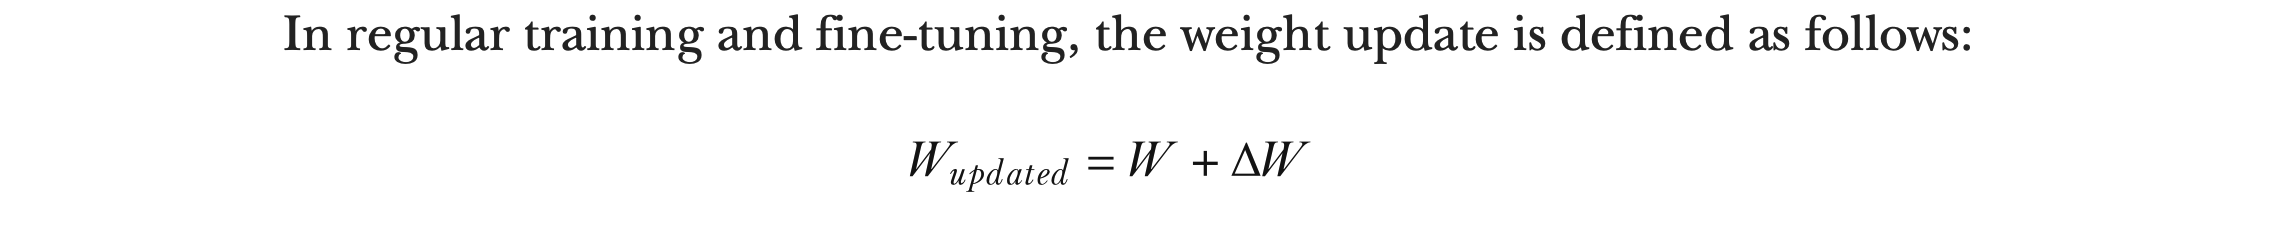

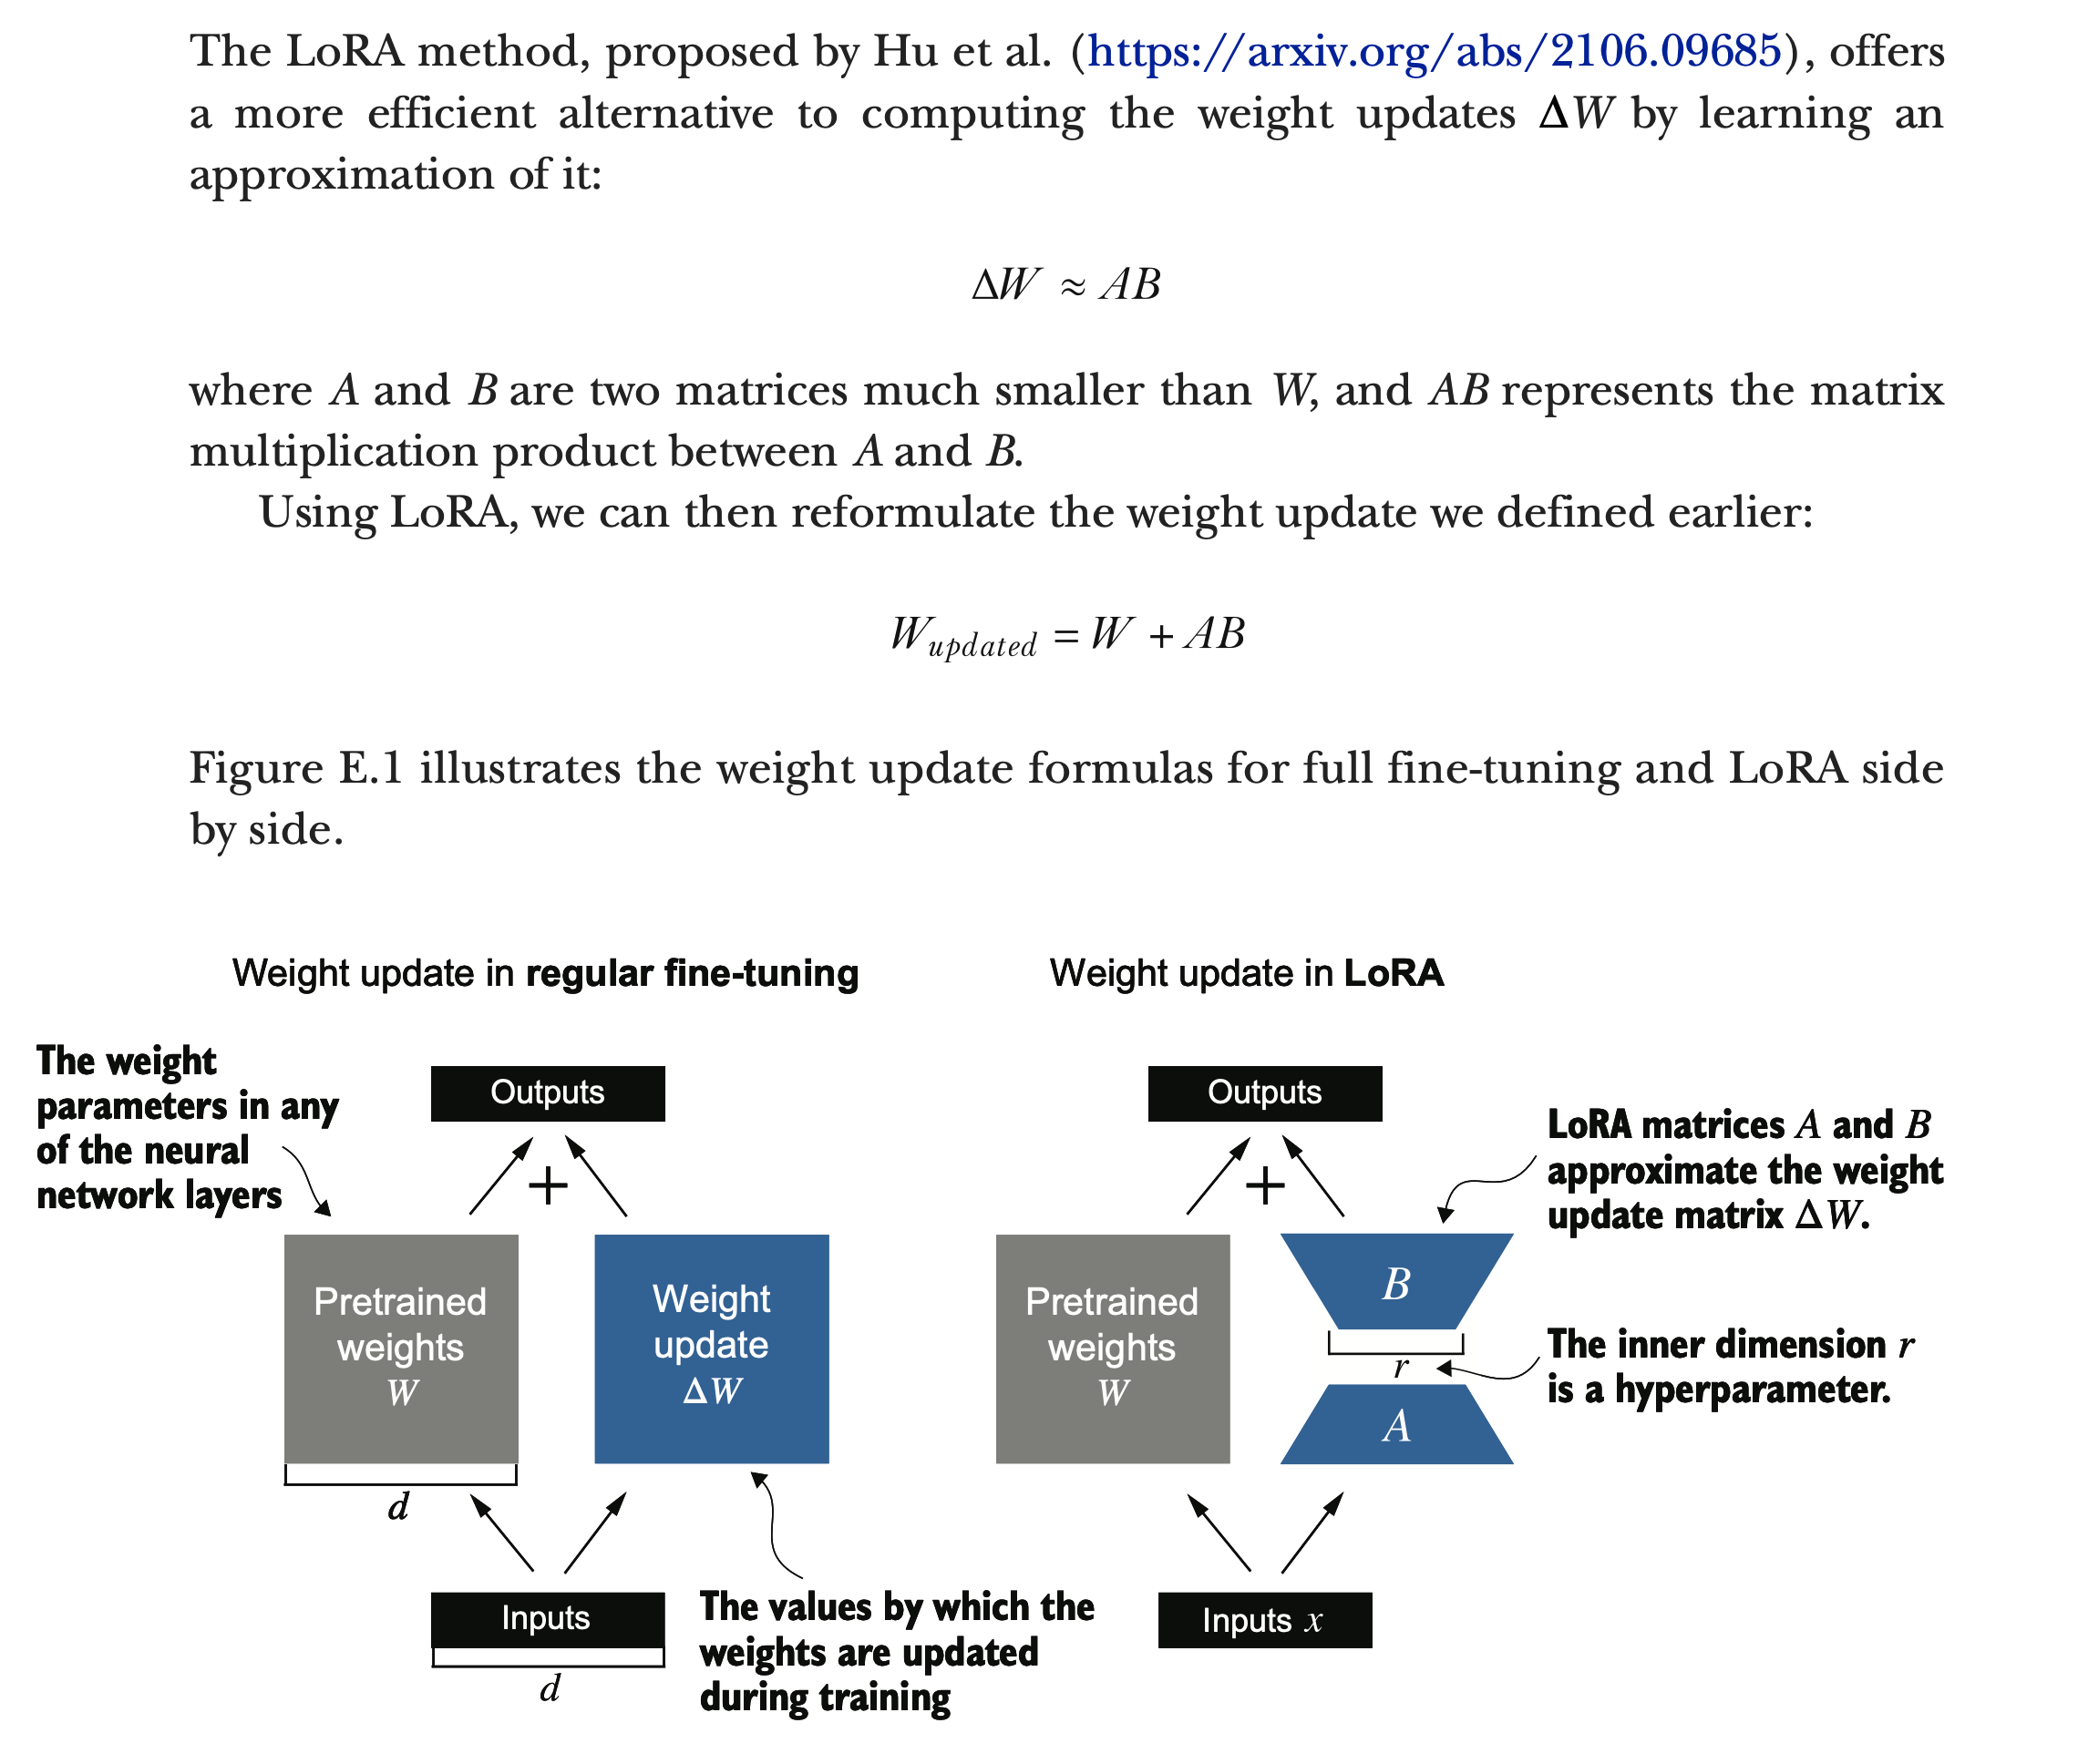

## Libs

In [ ]:
class LoRALayer(nn.Module):
  def __init__(self, in_dim, out_dim, rank, alpha):
    super().__init__()
    self.l1 = nn.Linear(in_dim, rank, bias=False)
    self.l2 = nn.Linear(rank, out_dim, bias=False)
    with torch.no_grad():
        self.l1.weight.fill_(0.0)
        # self.l2.weight.fill_(0.0)

    # Alpha is a regulation of the low-rank adaption.
    self.alpha = alpha

  def forward(self, x):
    # x: [B, in_dim]
    x = self.l1(x)  # [B, out_dim]
    x = self.l2(x)  # [B, in_dim]
    return x * self.alpha

In [ ]:
class LinearWithLoRA(nn.Module):
  def __init__(self, linear, rank, alpha):
    super().__init__()
    self.lora = LoRALayer(linear.in_features, linear.out_features, rank, alpha)
    self.linear = linear

  def forward(self, x):
    return self.lora(x) + self.linear(x)

In [ ]:
def replace_linear_with_lora(model, rank, alpha):
  for name, module in model.named_children():
    # print(f"{name=}, {type(module)=}")
    if isinstance(module, nn.Linear):
      setattr(model, name, LinearWithLoRA(module, rank, alpha))
    else:
      replace_linear_with_lora(module, rank, alpha)

## Training

In [ ]:
# @title Initialize the model

print(f"Initiating GPT-2 for config: {BASE_CONFIG}")

gpt_lora = GPTModel(BASE_CONFIG)
gpt_lora.eval()

load_weights_into_gpt(gpt_lora, params)
gpt_lora.to(device)

In [ ]:
# @title Test
def quick_test(model):
  torch.manual_seed(123)

  idx = text_to_token_ids("Is Texas in USA?", tokenizer).to(device)
  print(f"{idx.shape=}")
  for _ in range(5):
    print("=" * 80)

    out = generate(
        model,
        idx,
        max_new_tokens=25,
        context_size=BASE_CONFIG["context_length"],
        temperature=1.5,
        top_k=50)

    print(token_ids_to_text(out[0, :].to('cpu'), tokenizer))

quick_test(gpt_lora)

In [ ]:
# @title Model surgery to add LoRA
total_params = sum(p.numel() for p in gpt_lora.parameters() if p.requires_grad)
print(f"Total trainable parameters before: {total_params:,}")

for param in gpt_lora.parameters():
  param.requires_grad = False

total_params = sum(p.numel() for p in gpt_lora.parameters() if p.requires_grad)
print(f"Total trainable parameters after: {total_params:,}")

replace_linear_with_lora(gpt_lora, rank=32, alpha=16)
gpt_lora.to(device)

total_params = sum(p.numel() for p in gpt_lora.parameters() if p.requires_grad)
print(f"Total trainable LoRA parameters: {total_params:,}")

In [ ]:
gpt_lora

In [ ]:
for name, params in gpt_lora.named_parameters():
  print(f"{name=}, {params.requires_grad=}")

In [ ]:
for name, ps in gpt_lora.named_parameters():
  if name in ("out_head.lora.l1.weight", "out_head.lora.l2.weight", "trf_blocks.11.ffn.layers.2.lora.l2.weight", "out_head.linear.weight"):
    print(f"{name}: {ps}")


In [ ]:
# @title Test the initial LoRA doesn't change the output

# becasue the LoRA layers are initiated with zeros

quick_test(gpt_lora)

## Train

In [ ]:
import time
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(
    gpt_lora.parameters(), lr=0.00005, weight_decay=0.1
)
num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    gpt_lora, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

In [ ]:
for name, ps in gpt_lora.named_parameters():
  if name in ("out_head.lora.l1.weight", "out_head.lora.l2.weight", "trf_blocks.11.ffn.layers.2.lora.l2.weight", "out_head.linear.weight"):
    print(f"{name}: {ps}")


In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [ ]:
quick_test(gpt_lora)

## Eval

In [ ]:
samples = sample_resp(gpt_lora, n_examples=10000000)

samples_out_file = "lora-data-with-response.json"
with open(samples_out_file, "w") as file:
  json.dump(samples, file, indent=4)

with open(samples_out_file, "r") as file:
  loaded_samples_lora = json.load(file)
  assert len(loaded_samples_lora) == len(samples)
  assert loaded_samples_lora[0] == samples[0]

In [ ]:
scores = generate_model_scores(loaded_samples_lora, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

# Push the change to Github

In [ ]:
# del input
# commit_msg = input("Enter the commit message:")
commit_msg = "support sinosoidal pos emb"

%cd /content/$MODULE_NAME

!git add /content/$MODULE_NAME
!git commit -m "$commit_msg"

token = input("Enter the github token: ")

!git config --global user.email "lizhieffe@gmail.com"
!git config --global user.name "lizhieffe"

!git push https://$token@github.com/lizhieffe/"$MODULE_NAME".git main